This code is the work of Farokh Cooper (CWID: 20016578)
Parts of this code have been inspired by the Coursera course Special Recommendation Systems as this was a novel approach for me





#Importing headers 

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import os
import glob
from datetime import date
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:root:Initializing MLIR with module: _site_initialize_0
DEBUG:root:Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._site_initialize_0' from '/usr/local/lib/python3.8/dist-packages/jaxlib/mlir/_mlir_libs/_site_initialize_0.so'>
DEBUG:jax._src.path:etils.epath found. Using etils.epath for file I/O.


- After the epoch of the model is finished, the log is saved to logs to check the training process, and the model per epoch is saved to weights. 

This is a generic piece of code inspired by Coursera course Special Recommendation Systems as it cannot be implemented in another way.

In [12]:
## Create the logs and weights files if they don't already exist.
## This helps to 

if glob.glob('logs') != ['logs']:
    os.mkdir('logs')
else:
    pass

if glob.glob('weights') != ['weights']:
    os.mkdir('weights')
else:
    pass

In [13]:
# Set and save the name of the model to be trained in log_model

log_model = 'nmf'       ## saving the model to nmf

today = date.today()
log_formatter = logging.Formatter("%(asctime)s %(message)s")
logger = logging.getLogger()

log_file_name = "./logs/{}_{}".format(today, log_model)       ## adding the log file

file_handler = logging.FileHandler("{}.log".format(log_file_name))
file_handler.setFormatter(log_formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

#Data Preprocessing

Using the 1 million MovieLens dataset as the larger 20 million dataset is not able to be used to create the NN due to memory running out.

In [16]:
## Setting the ratings columns

ratings_cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=ratings_cols)
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [17]:
pd.read_csv('ratings.dat').head()

,1::1193::5::978300760
0,1::661::3::978302109
1,1::914::3::978301968
2,1::3408::4::978300275
3,1::2355::5::978824291
4,1::1197::3::978302268


In [19]:
ratings['UserID'].isnull().any()

False

In [20]:
ratings['MovieID'].isnull().any()

False

In [22]:
ratings['Rating'].isnull().any()


False

In [25]:
user_ratings_count = ratings.groupby(['UserID']).count()['MovieID']
movie_ratings_count = ratings.groupby(['MovieID']).count()['UserID']
print("Number of unique users in ratings data:", len(user_ratings_count))
print("Number of unique movies in ratings data:", len(movie_ratings_count))

Number of unique users in ratings data: 6040
Number of unique movies in ratings data: 3706


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:fin

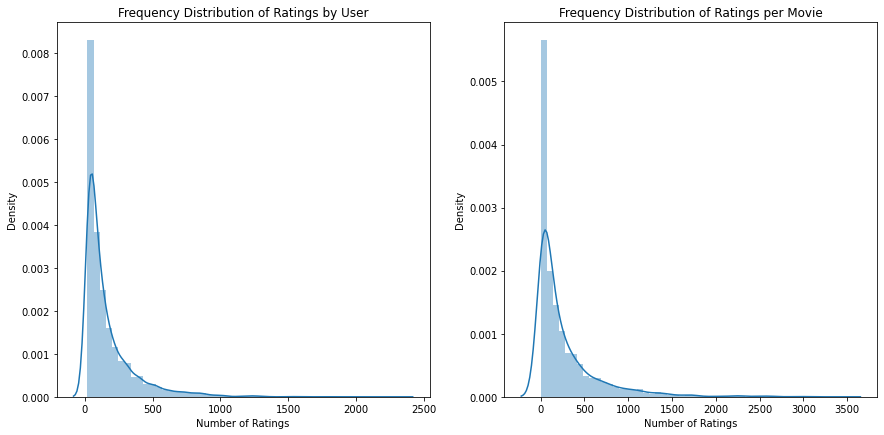

In [26]:
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(user_ratings_count, ax = ax1)
ax1.set_title('Frequency Distribution of Ratings by User')
sns.distplot(movie_ratings_count, ax = ax2)
ax2.set_title('Frequency Distribution of Ratings per Movie')

ax1.set_xlabel('Number of Ratings')
ax2.set_xlabel('Number of Ratings')
plt.subplots_adjust(0.1, 0.1, 2, 1.4)
plt.show()

# Constructing the Model

- Setting the Dataloader and the model settings for implementing PyTorch:



In [27]:
## Creating a dataset class consisting of users for UserID, items for MovieID, and y for the rating (output).
## Importing dataset and dataloader objects from PyTorch
## This piece of code is inspired by the PyTorch documentation. 

from torch.utils.data import Dataset, TensorDataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, users, items, y):
        self.x = torch.cat([
            torch.LongTensor(users).unsqueeze(0).transpose(0, 1),
            torch.LongTensor(items).unsqueeze(0).transpose(0, 1)
        ], axis=1)
        self.y = torch.FloatTensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

In [28]:
## Configuring the data train_dataset by labeling users and items from the custom_dataset using LabelEncoder
## This creates a training data loader object.

from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()      ## Label Encoders are used to convert categorical data to numerical data
le2 = preprocessing.LabelEncoder()

batch_size = 256

train_dataset = CustomDataset(          ## Creating our training dataset
    le1.fit_transform(ratings.UserID),
    le2.fit_transform(ratings.MovieID),
    ratings.Rating.values
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [29]:
## Configureing the model by setting the number of unique users found , the number of movies, and the dimension to embedding.


class MF(nn.Module):                                    ## Creating PyTorch Neural Network module
    def __init__(self, user_ratings_count, movie_ratings_count, emb_size=128):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(user_ratings_count, emb_size)
        self.item_emb = nn.Embedding(movie_ratings_count, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):              ## The forward function is defined
        x, y = data[:,:1], data[:,1:]
        u, v = self.user_emb(x), self.item_emb(y)
        return (u.squeeze(1) * v.squeeze(1)).sum(1)   ## The rating is calculated by dot producting the embedding values ​​of users and movies.

Generic piece of code inspired by the Coursera course Special Recommendation Systems to check whether our device has a GPU and set the device to GPU if available, else setting it to CPU by default.

In [34]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print('The device is: %s' % device)

The device is: cpu


In [39]:
model = MF(user_ratings_count, movies_rating_count, emb_size=128).to(device)
print('Constructing the model with:\n\n', model)

Constructing the model with:

 MF(
  (user_emb): Embedding(6040, 128)
  (item_emb): Embedding(3706, 128)
)


In [41]:
## Setting the optimizer, learning rate and the loss function
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      ## Selecting the adam optimizer
loss_fn = torch.nn.MSELoss()

In [44]:
## Training the model here
model.train()

## Setting the number of epochs to be 10, and using the Neural network to train the data
epochs = 10

for e in range(epochs):
    print('start : '+str(e)+' epoch')
    avg_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), "./weights/{}_{}.pt".format(log_model,e+1))      ## generic piece of code to save the model dictionary obtained in case kernel dies
    print("e{}: loss: {}".format(e+1, loss/(batch_idx+1)))
    logger.info("e{}: loss: {}".format(e+1, loss/(batch_idx+1)))                    ## saving the loss value to the logs too
print('training complete')


start : 0 epoch


INFO:root:e1: loss: 0.00023638216953258961


e1: loss: 0.00023638216953258961
start : 1 epoch


INFO:root:e2: loss: 0.00038643303560093045


e2: loss: 0.00038643303560093045
start : 2 epoch


INFO:root:e3: loss: 0.0005617801798507571


e3: loss: 0.0005617801798507571
start : 3 epoch


INFO:root:e4: loss: 0.0002994187525473535


e4: loss: 0.0002994187525473535
start : 4 epoch


INFO:root:e5: loss: 0.0010843522613868117


e5: loss: 0.0010843522613868117
start : 5 epoch


INFO:root:e6: loss: 0.0008755346643738449


e6: loss: 0.0008755346643738449
start : 6 epoch


INFO:root:e7: loss: 0.0004164517449680716


e7: loss: 0.0004164517449680716
start : 7 epoch


INFO:root:e8: loss: 0.0011404840042814612


e8: loss: 0.0011404840042814612
start : 8 epoch


INFO:root:e9: loss: 0.00075065455166623


e9: loss: 0.00075065455166623
start : 9 epoch


INFO:root:e10: loss: 0.0003921790630556643


e10: loss: 0.0003921790630556643
training complete


# Constructing the model:

In [45]:
## We evaluate the model again

model.eval()

MF(
  (user_emb): Embedding(6040, 128)
  (item_emb): Embedding(3706, 128)
)

In [46]:
## We generate the data to verify our training results 
ratings['le_UserID'] = le1.fit_transform(ratings.UserID)
ratings['le_MovieID'] = le1.fit_transform(ratings.MovieID)

ratings

,UserID,MovieID,Rating,Timestamp,le_UserID,le_MovieID
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,6039,1019
1000205,6040,1094,5,956704887,6039,1022
1000206,6040,562,5,956704746,6039,548
1000207,6040,1096,4,956715648,6039,1024


In [47]:
## We coonvert the values of our data to LongTensor format as int 64 may not be enough to store, and put it in the model to predict the calculated ratings

val_tensor = torch.LongTensor(ratings[['le_UserID', 'le_MovieID']].values).to(device)
pred = model(torch.LongTensor(ratings[['le_UserID', 'le_MovieID']].values).to(device))

In [48]:
## Adding the predicted values ​​to the ratings Data Frame
ratings['pred_Rating'] = pred.to('cpu').detach().numpy()

# Here we finally obtain our Ratings prediction which can be seen side-by-side with the real ratings.

In [53]:
ratings

,UserID,MovieID,Rating,Timestamp,le_UserID,le_MovieID,pred_Rating
0,1,1193,5,978300760,0,1104,0.112685
1,1,661,3,978302109,0,639,5.103359
2,1,914,3,978301968,0,853,5.182773
3,1,3408,4,978300275,0,3177,2.956620
4,1,2355,5,978824291,0,2162,3.456702
...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,6039,1019,1.087199
1000205,6040,1094,5,956704887,6039,1022,4.378617
1000206,6040,562,5,956704746,6039,548,5.147697
1000207,6040,1096,4,956715648,6039,1024,4.049432
